### And welcome to Week 4, Day 3 - more LangGraph..

In [3]:
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict


In [4]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

### First, let's go set up LangSmith!

https://langsmith.com

### Next, here is a useful function in LangChain community:

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")

'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. Paris, the capital city of France, is often referred to as the “City of Light” (La Vi

### Now here is a LangChain wrapper class for converting functions into Tools

In [4]:
from langchain_core.tools import Tool

tool_search =Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need more information from an online search"
    )



### Now we can try out the tool the langchain way

In [7]:
tool_search.invoke("What is the capital of Taiwan?")

"Taipei officially Taipei City, is the capital and a special municipality of Taiwan. Located in Northern Taiwan, Taipei City is an enclave of the ... Taiwan is an island in the western Pacific Ocean that lies roughly 100 miles (160 km) off the coast of southeastern China. Taipei, in the north, ... Taipei City is the capital of Taiwan (also known as the Republic of China), an island country located 160 kilometers (100 miles) from the southeastern coast of ... The capital is Taipei, which, along with New Taipei City and Keelung, forms the largest metropolitan area of Taiwan. Other major cities include ... Taipei. A colourful big city. The capital of Taiwan. Famous for the Raohe Night Market, with exceptional street food. Taipei (Taibei), provisional capital of the Republic of China - Taiwan, the main administrative, commercial, manufacturing, and cultural center of the island. ... The largest metropolitan area is formed by Taipei (the capital), New Taipei City, and Keelung. With around 2

In [8]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [9]:
tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

tool_push.invoke("帅哥你好呀")

### Back to the Graph from yesterday

One small change - using TypedDict instead of BaseModel for the State object

When we implement tools, we always need to make 2 changes to the code:

1. Changes to provide the tools to OpenAI in json when we make the call

2. Changes to handle the results back: look for the model staying that the finish_reason=="tool_calls" and then retrieve the call, run the function, provide the results.

### Bring them together

In [10]:
tools = [tool_search, tool_push]

In [11]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [12]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [13]:
# This is different:

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [15]:
# Step 3: Create a Node

# this method returns the reply from the llm
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

ValueError: Node `chatbot` already present.

In [16]:
# Step 4: Create Edges

# tools_condition is a langgraph feature that determines whether tools should be used. Basically it parses openAI finishcode
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

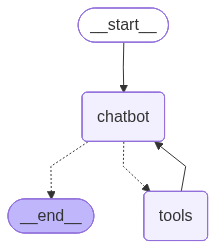

In [17]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [18]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.

Why isn't this handling memory?

### This is a crucial point for understanding LangGraph

> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.


One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

In [19]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

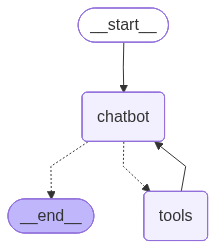

In [20]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5, the new thing here is checkpointer is introduced as argument 
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    #config is the new thing here in the invoke call. It keeps track of the convo in thread
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content="alright let's try again. Is Taiwan a country? ", additional_kwargs={}, response_metadata={}, id='7a058c06-8b63-4bb5-81c9-5d4f8fb5e935')]}
{'messages': [HumanMessage(content="alright let's try again. Is Taiwan a country? ", additional_kwargs={}, response_metadata={}, id='7a058c06-8b63-4bb5-81c9-5d4f8fb5e935'), AIMessage(content='The status of Taiwan is a complex and sensitive issue. Taiwan operates as a separate entity with its own government, economy, and democratic political system. It has its own constitution and conducts foreign relations to some extent. However, many countries do not officially recognize Taiwan as a sovereign nation due to the "One China" policy, which considers Taiwan a part of China. \n\nThe situation is further complicated by international politics, where some countries recognize the People\'s Republic of China (PRC) as the sole legal government of China and do not maintain formal diplomatic ties with Taiwan. Despite this, Tai

In [22]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content="alright let's try again. Is Taiwan a country? ", additional_kwargs={}, response_metadata={}, id='7a058c06-8b63-4bb5-81c9-5d4f8fb5e935'), AIMessage(content='The status of Taiwan is a complex and sensitive issue. Taiwan operates as a separate entity with its own government, economy, and democratic political system. It has its own constitution and conducts foreign relations to some extent. However, many countries do not officially recognize Taiwan as a sovereign nation due to the "One China" policy, which considers Taiwan a part of China. \n\nThe situation is further complicated by international politics, where some countries recognize the People\'s Republic of China (PRC) as the sole legal government of China and do not maintain formal diplomatic ties with Taiwan. Despite this, Taiwan functions similarly to a country in many respects, and its status is a subject of ongoing debate.', additional_kwargs={'refusal': None}, response_met

In [23]:
# Most recent first

list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content="alright let's try again. Is Taiwan a country? ", additional_kwargs={}, response_metadata={}, id='7a058c06-8b63-4bb5-81c9-5d4f8fb5e935'), AIMessage(content='The status of Taiwan is a complex and sensitive issue. Taiwan operates as a separate entity with its own government, economy, and democratic political system. It has its own constitution and conducts foreign relations to some extent. However, many countries do not officially recognize Taiwan as a sovereign nation due to the "One China" policy, which considers Taiwan a part of China. \n\nThe situation is further complicated by international politics, where some countries recognize the People\'s Republic of China (PRC) as the sole legal government of China and do not maintain formal diplomatic ties with Taiwan. Despite this, Taiwan functions similarly to a country in many respects, and its status is a subject of ongoing debate.', additional_kwargs={'refusal': None}, response_me

### LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

### And now let's store in SQL

### And this is the power of LangGraph.

In [1]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory_new.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

In [5]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

NameError: name 'State' is not defined

In [28]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='OK remember the sensitive topic we talked about?', additional_kwargs={}, response_metadata={}, id='64e77339-c59a-4f48-8d07-0814700f9fe0')]}
{'messages': [HumanMessage(content='OK remember the sensitive topic we talked about?', additional_kwargs={}, response_metadata={}, id='64e77339-c59a-4f48-8d07-0814700f9fe0'), AIMessage(content="I don't have the ability to remember past conversations. However, I'm here to help with any questions or topics you'd like to discuss. What would you like to talk about?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 97, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_11f3029f6b', 'id': 'chatcmpl-ClrkLRYvLrHgZAtqGb